**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 优化算法

## 梯度下降和随机梯度下降

>(Restart your kernel here)

在本节中，我们将介绍梯度下降（gradient descent）的工作原理。虽然梯度下降在深度学习中很少被直接使用，但理解梯度的意义以及沿着梯度反方向更新自变量可能降低目标函数值的原因是学习后续优化算法的基础。随后，我们将引出随机梯度下降（stochastic gradient descent）。



### 一维梯度下降

我们先以简单的一维梯度下降为例，解释梯度下降算法可能降低目标函数值的原因。假设连续可导的函数 $f: \mathbb{R} \rightarrow \mathbb{R}$ 的输入和输出都是标量。给定绝对值足够小的数 $\epsilon$, 根据泰勒展开公式，我们得到以下的近似:
$$
f(x+\epsilon) \approx f(x)+\epsilon f^{\prime}(x) .
$$
这里 $f^{\prime}(x)$ 是函数 $f$ 在 $x$ 处的梯度。一维函数的梯度是一个标量，也称导数。
接下来，找到一个常数 $\eta>0$, 使得 $\left|\eta f^{\prime}(x)\right|$ 足够小，那么可以将 $\epsilon$ 替换为 $-\eta f^{\prime}(x)$ 并得到
$$
f\left(x-\eta f^{\prime}(x)\right) \approx f(x)-\eta f^{\prime}(x)^{2} .
$$
如果导数 $f^{\prime}(x)\neq0$, 那么 $\eta f^{\prime}(x)^{2}>0$, 所以
$$
f\left(x-\eta f^{\prime}(x)\right) \lesssim f(x)
$$
这意味着，如果通过
$$
x \leftarrow x-\eta f^{\prime}(x)
$$
来迭代 $x$, 函数 $f(x)$ 的值可能会降低。因此在梯度下降中，我们先选取一个初始值 $x$ 和常数 $\eta>0$, 然后不断通过上式来迭代 $x$, 直到达到停止条件，例如 $f^{\prime}(x)^{2}$ 的值已足够小或迭代次数已达到某个值。

下面我们以目标函数 $f(x)=x^{2}$ 为例来看一看梯度下降是如何工作的。虽然我们知道最小化 $f(x)$ 的解为 $x=0$, 这里依然使用这个简单函数来观察 $x$ 是如何被迭代的。首先，导入本节实验所需的包或模块。

In [1]:
%matplotlib inline
import numpy as np
import torch
import math
import dl4wm

接下来使用 $x=10$ 作为初始值，并设 $\eta=0.2$ 。使用梯度下降对 $x$ 迭代10次，可见最终 $x$ 的值较接近最优解。

In [2]:
def gd(eta):
    x = 10
    results = [x]
    for _ in range(10):
        x -= eta * 2 * x  # f(x) = x * x 的导数为 f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


下面将绘制出自变量 $x$ 的迭代轨迹。

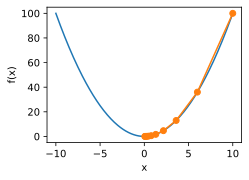

In [3]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    dl4wm.set_figsize()
    dl4wm.plt.plot(f_line, [x * x for x in f_line])
    dl4wm.plt.plot(res, [x * x for x in res], '-o')
    dl4wm.plt.xlabel('x')
    dl4wm.plt.ylabel('f(x)')

show_trace(res)

### 学习率

上述梯度下降算法中的正数 $\eta$ 通常叫作学习率。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致 $x$ 更新缓慢从而需要
更多的迭代才能得到较好的解。

下面展示使用学习率 $\eta=0.05$ 时自变量 $x$ 的迭代轨迹。可见，同样迭代10次后，当学习率过小时，最终 $x$ 的值依然与最优解存在较大偏差。

epoch 10, x: 3.4867844009999995


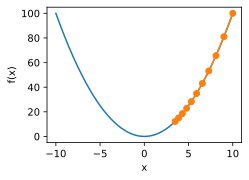

In [4]:
show_trace(gd(0.05))

如果使用过大的学习率， $\left|\eta f^{\prime}(x)\right|$ 可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代 $x$ 会降低 $f(x)$ 的值。

举个例子，当设学习率 $\eta=1.1$ 时，可以看到 $x$ 不断越过 (overshoot) 最优解 $x=0$ 并逐渐发散。

epoch 10, x: 61.917364224000096


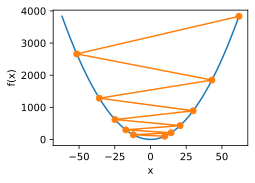

In [5]:
show_trace(gd(1.1))

### 多维梯度下降

在了解了一维梯度下降之后，我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。假设目标函数 $f: \mathbb{R}^{d} \rightarrow \mathbb{R}$ 的输 入是一个 $d$ 维向量 $\boldsymbol{x}=\left[x_{1}, x_{2}, \ldots, x_{d}\right]^{\top}$ 。目标函数 $f(\boldsymbol{x})$ 有关 $\boldsymbol{x}$ 的梯度是一个由 $d$ 个偏导数组成的向量

$$
\nabla_{\boldsymbol{x}} f(\boldsymbol{x})=\left[\frac{\partial f(\boldsymbol{x})}{\partial x_{1}}, \frac{\partial f(\boldsymbol{x})}{\partial x_{2}}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_{d}}\right]^{\top}
$$

为表示简洁，我们用 $\nabla f(\boldsymbol{x})$ 代替 $\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$ 。梯度中每个偏导数元素 $\partial f(\boldsymbol{x}) / \partial x_{i}$ 代表着 $f$ 在 $\boldsymbol{x}$ 有关输入 $x_{i}$ 的变化率。为了测量 $f$ 沿着单 位向量 $\boldsymbol{u}$ (即 $\|\boldsymbol{u}\|=1$ ) 方向上的变化率，在多元微积分中，我们定义 $f$ 在 $\boldsymbol{x}$ 上沿着 $\boldsymbol{u}$ 方向的方向导数为

$$
\mathrm{D}_{\boldsymbol{u}} f(\boldsymbol{x})=\lim _{h \rightarrow 0} \frac{f(\boldsymbol{x}+h \boldsymbol{u})-f(\boldsymbol{x})}{h}
$$

依据方向导数性质，以上方向导数可以改写为

$$
\mathrm{D}_{\boldsymbol{u}} f(\boldsymbol{x})=\nabla f(\boldsymbol{x}) \cdot \boldsymbol{u} .
$$

方向导数 $\mathrm{D}_{u} f(\boldsymbol{x})$ 给出了 $f$ 在 $\boldsymbol{x}$ 上沿着所有可能方向的变化率。为了最小化 $f$, 我们希望找到 $f$ 能被降低最快的方向。因此，我们可以通过单位向量 $\boldsymbol{u}$ 来最小化方向导数 $\mathrm{D}_{u} f(\boldsymbol{x})$。

由于 $D_{u} f(\boldsymbol{x})=\|\nabla f(\boldsymbol{x})\| \cdot\|\boldsymbol{u}\| \cdot \cos (\theta)=\|\nabla f(\boldsymbol{x})\| \cdot \cos (\theta)$，其中 $\theta$ 为梯度 $\nabla f(\boldsymbol{x})$ 和单位向量 $\boldsymbol{u}$ 之间的夹角，当 $\theta=\pi$ 时, $\cos (\theta)$ 取得最小值 $-1$ 。因此，当 $\boldsymbol{u}$ 在梯度方向 $\nabla f(\boldsymbol{x})$ 的相反方向时，方向导数 $\mathrm{D}_{u} f(\boldsymbol{x})$ 被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数 $f$ 的值

$$
\boldsymbol{x} \leftarrow \boldsymbol{x}-\eta \nabla f(\boldsymbol{x}) \text { . }
$$

同样，其中 $\eta$ (取正数) 称作学习率。

下面我们构造一个输入为二维向量 $\boldsymbol{x}=\left[x_{1}, x_{2}\right]^{\top}$ 和输出为标量的目标函数 $f(\boldsymbol{x})=x_{1}^{2}+2 x_{2}^{2}$ 。那么，梯度 $\nabla f(\boldsymbol{x})=\left[2 x_{1}, 4 x_{2}\right]^{\top}$ 。
我们将观察梯度下降从初始位置 $[-5,-2]$ 开始对自变量 $x$ 的迭代轨迹。我们先定义两个辅助函数，第一个函数使用给定的自变量更新函数，从初始位置 $[-5,-2]$ 开始迭代自变量 $\boldsymbol{x}$ 共20次，第二个函数对自变量 $\boldsymbol{x}$ 的迭代轨迹进行可视化。

In [6]:
def train_2d(trainer):  # 本函数将保存在 dl4wm 包中方便以后使用
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本讲后续几节会使用
    results = [(x1, x2)]
    for _ in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  # 本函数将保存在 dl4wm 包中方便以后使用
    dl4wm.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    dl4wm.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    dl4wm.plt.xlabel('x1')
    dl4wm.plt.ylabel('x2')

然后，观察学习率为 $0.1$ 时自变量的迭代轨迹。使用梯度下降对自变量 $\boldsymbol{x}$ 迭代20次后，可见最终 $\boldsymbol{x}$ 的值较接近最优解 $[0,0]$。

epoch 20, x1 -0.057646, x2 -0.000073


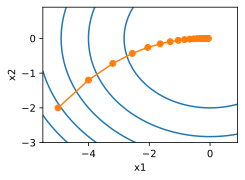

In [7]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

### 随机梯度下降

在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均。设 $f_{i}(\boldsymbol{x})$ 是有关索引为 $i$ 的训练数据样本的损失函数, $n$ 是训练数据样本数， $\boldsymbol{x}$ 是模型的参数向量，那么目标函数定义为

$$
f(\boldsymbol{x})=\frac{1}{n} \sum_{i=1}^{n} f_{i}(\boldsymbol{x})
$$

目标函数在 $\boldsymbol{x}$ 处的梯度计算为

$$
\nabla f(\boldsymbol{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\boldsymbol{x})
$$

如果使用梯度下降，每次自变量迭代的计算开销为 $\mathcal{O}(n)$, 它随着 $n$ 线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的
计算开销很高。

随机梯度下降（stochastic gradient descent, SGD）减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引 $i \in\{1, \ldots, n\}$, 并计算梯度 $\nabla f_{i}(\boldsymbol{x})$ 来迭代 $\boldsymbol{x}$.

$$
\boldsymbol{x} \leftarrow \boldsymbol{x}-\eta \nabla f_{i}(\boldsymbol{x})
$$

这里 $\eta$ 同样是学习率。可以看到每次迭代的计算开销从梯度下降的 $\mathcal{O}(n)$ 降到了常数 $\mathcal{O}(1)$ 。值得强调的是，随机梯度 $\nabla f_{i}(\boldsymbol{x})$ 是对梯度 $\nabla f(\boldsymbol{x})$ 的无偏估计

$$
E_{i} \nabla f_{i}(\boldsymbol{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\boldsymbol{x})=\nabla f(\boldsymbol{x})
$$

这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

下面我们通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降，以此来比较它与梯度下降的区别。

epoch 20, x1 -0.301735, x2 0.027088


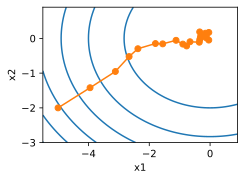

In [8]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

可以看到，随机梯度下降中自变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的无意义的干扰。

### 小结

- 使用适当的学习率，沿着梯度反方向更新自变量可能降低目标函数值。梯度下降重复这一更新过程直到得到满足要求的解。
- 学习率过大或过小都有问题。一个合适的学习率通常是需要通过多次实验找到的。
- 当训练数据集的样本较多时，梯度下降每次迭代的计算开销较大，因而随机梯度下降通常更受青睐。

## 小批量随机梯度下降

>(Restart your kernel here)

在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为批量梯度下降（batch gradient descent）。而随机梯 度下降在每次迭代中只随机采样一个样本来计算梯度。正如我们在前几章中所看到的，我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度。下面就来描述小批量随机梯度下降。

设目标函数 $f(\boldsymbol{x}): \mathbb{R}^{d} \rightarrow \mathbb{R}_{\circ}$ 在迭代开始前的时间步设为0。该时间步的自变量记为 $\boldsymbol{x}_{0} \in \mathbb{R}^{d}$, 通常由随机初始化得到。在接下来的每一个时间步 $t>0$ 中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量 $\mathcal{B}_{t \circ}$ 我们可以通过重复采样 (sampling with replacement) 或者不重复采样（sampling without replacement) 得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用

$$
\boldsymbol{g}_{t} \leftarrow \nabla f_{\mathcal{B}_{t}}\left(\boldsymbol{x}_{t-1}\right)=\frac{1}{\mid \mathcal{B}\mid} \sum_{i \in \mathcal{B}_{t}} \nabla f_{i}\left(\boldsymbol{x}_{t-1}\right)
$$

来计算时间步 $t$ 的小批量 $\mathcal{B}_{t}$ 上目标函数位于 $\boldsymbol{x}_{t-1}$ 处的梯度 $\boldsymbol{g}_{t}$ 这里 $|\mathcal{B}|$ 代表批量大小，即小批量中样本的个数，是一个超参数。同随机 梯度一样，重复采样所得的小批量随机梯度 $\boldsymbol{g}_{t}$ 也是对梯度 $\nabla f\left(\boldsymbol{x}_{t-1}\right)$ 的无偏估计。给定学习率 $\eta_{t}($ 取正数），小批量随机梯度下降对 自变量的迭代如下

$$
\boldsymbol{x}_{t} \leftarrow \boldsymbol{x}_{t-1}-\eta_{t} \boldsymbol{g}_{t} .
$$

基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中, (小批量) 随机梯度下降的学习率可以在迭代过程中自我衰减，例如 $\eta_{t}=\eta t^{\alpha} $ (通常 $\alpha=-1$ 或者 $-0.5$ )，$\eta_{t}=\eta \alpha^{t}$ (如 $\alpha=0.95$ ) 或者每迭代若干次后将学习率衰减一次。如此一来，学习率和（小批量）随机梯度乘积的方差会减小。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。

小批量随机梯度下降中每次迭代的计算开销为 $\mathcal{O}(|\mathcal{B}|)$ 。当批量大小为1时，该算法即为随机梯度下降; 当批量大小等于训练数据样本数时，该算法即为梯度下降。当批量较小时，每次迭代中使用的样本少，这会导致并行处理和内存使用效率变低。这使得在计算同样数目样本的情况下比使用更大批量时所花时间更多。当批量较大时，每个小批量梯度里可能含有更多的咒余信息。为了得到较好的解，批量较大时比批量较小时需要计算的样本数目可能更多，例如增大迭代周期数。

### 读取数据

本节里我们将使用一个来自 NASA 的测试不同飞机机翼噪音的数据集来比较各个优化算法。我们使用该数据集的前 1,500 个样本和 5 个特征，并使用标准化对数据进行预处理。

- 飞机机翼噪音数据集。https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

In [1]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import dl4wm

def get_data_NASA():  # 本函数已保存在 dl4wm 包中方便以后使用
    data = np.genfromtxt('Datasets/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
           torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_NASA()
features.shape # torch.Size([1500, 5])

torch.Size([1500, 5])

### 从零开始实现

「线性回归的从零开始实现」节中已经实现过小批量随机梯度下降算法。我们在这里将它的输入参数变得更加通用，主要是为了方便本讲后面介绍的其他优化算法也可以使用同样的输入。具体来说，我们添加了一个状态输入 `states` 并将超参数放在字典 `hyperparams` 里。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [2]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

下面实现一个通用的训练函数，以方便本讲后面介绍的其他优化算法使用。它初始化一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [3]:
# 本函数已保存在 dl4wm 包中方便以后使用
def train_Opt(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = dl4wm.linreg, dl4wm.squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    dl4wm.set_figsize()
    dl4wm.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    dl4wm.plt.xlabel('epoch')
    dl4wm.plt.ylabel('loss')

当批量大小为样本总数 1,500 时，优化使用的是梯度下降。梯度下降的 1 个迭代周期对模型参数只迭代 1 次。可以看到 6 次迭代后目标函数值（训练损失）的下降趋向了平稳。

loss: 0.243778, 0.099863 sec per epoch


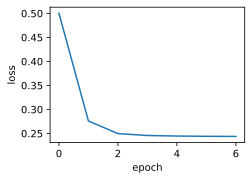

In [4]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_Opt(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

当批量大小为 1 时，优化使用的是随机梯度下降。为了简化实现，有关（小批量）随机梯度下降的实验中，我们未对学习率进行自我衰减，而是直接采用较小的常数学习率。随机梯度下降中，每处理一个样本会更新一次自变量（模型参数），一个迭代周期里会对自变量进行 1,500 次更新。可以看到，目标函数值的下降在 1 个迭代周期后就变得较为平缓。

loss: 0.244749, 4.885074 sec per epoch


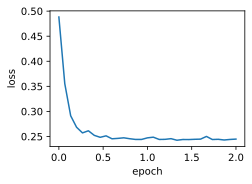

In [5]:
train_sgd(0.005, 1)

虽然随机梯度下降和梯度下降在一个迭代周期里都处理了 1,500 个样本，但实验中随机梯度下降的一个迭代周期耗时更多。这是因为随机梯度下降在一个迭代周期里做了更多次的自变量迭代，而且单样本的梯度计算难以有效利用矢量计算。

当批量大小为 10 时，优化使用的是小批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

loss: 0.244206, 0.782982 sec per epoch


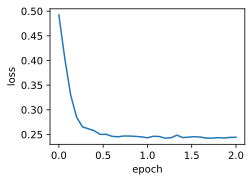

In [6]:
train_sgd(0.05, 10)

### 简洁实现

在 PyTorch 里可以通过创建 `optimizer` 实例来调用优化算法。这能让实现更简洁。下面实现一个通用的训练函数，它通过优化算法的函数 `optimizer_fn` 和超参数 `optimizer_hyperparams` 来创建 `optimizer` 实例。

In [7]:
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_Opt(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    dl4wm.set_figsize()
    dl4wm.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    dl4wm.plt.xlabel('epoch')
    dl4wm.plt.ylabel('loss')

使用 PyTorch 重复上一个实验。

loss: 0.246680, 0.808251 sec per epoch


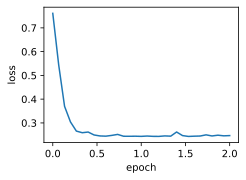

In [8]:
train_pytorch_Opt(optim.SGD, {"lr": 0.05}, features, labels, 10)

### 小结

- 小批量随机梯度每次随机均匀采样一个小批量的训练样本来计算梯度。
- 在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减。
- 通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。